In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [2]:
# Load the dataset
file_path = 'combined_df.csv'
data = pd.read_csv(file_path)

data = data[
    (data['Year'] >= 2020) &
    (data['Headliner'].str.contains('"', na=False)) &
    (~data['Support'].isna()) &
    (data['Genre'] != 'Family Entertainment')
  ]


/tmp/ipykernel_5518/4095921683.py:3: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:

# extract date features
def extract_date_features(df):
    df['Event Date'] = pd.to_datetime(df['Event Date'])
    df['Year'] = df['Event Date'].dt.year
    df['Month'] = df['Event Date'].dt.month
    df['Day of Week'] = df['Event Date'].dt.dayofweek
    return df


In [4]:

data = extract_date_features(data)

# target var and features
target = 'Avg. Gross USD'
features = ['Number of Shows', 'Avg. Event Capacity', 'Ticket Price Min USD', 'Ticket Price Max USD', 
            'Market', 'Month', 'Day of Week']


In [5]:

# cols_to_convert = [
#     'Avg. Gross USD', 'Avg. Tickets Sold', 'Avg. Event Capacity', 
#     'Ticket Price Min USD', 'Ticket Price Max USD', 'Ticket Price Avg. USD'
# ]
# for col in cols_to_convert:
#     data[col] = pd.to_numeric(data[col].str.replace('[^0-9.]', '', regex=True), errors='coerce')



Text(0, 0.5, 'Frequency')

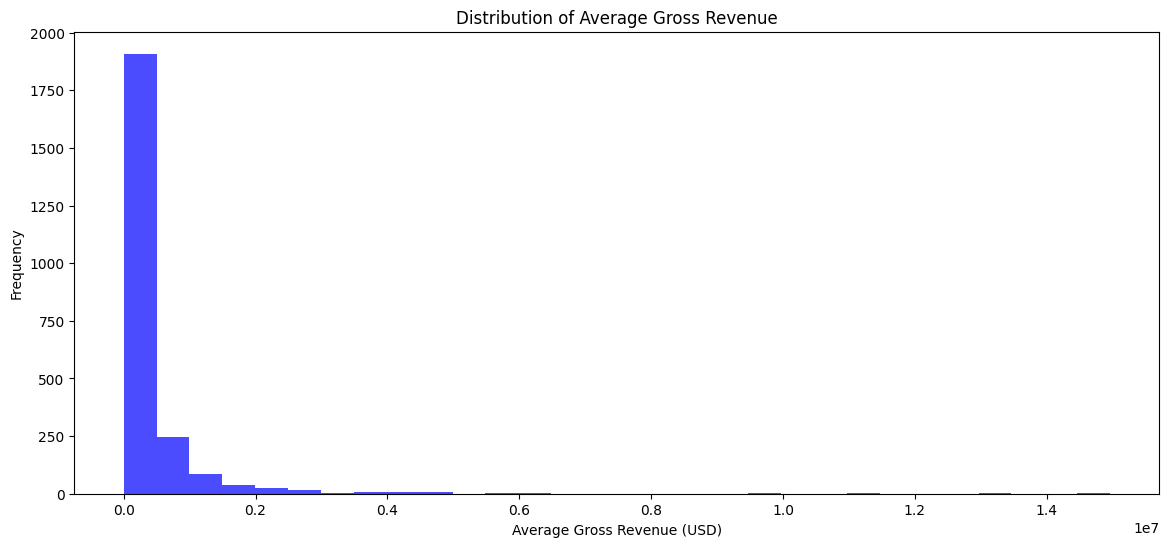

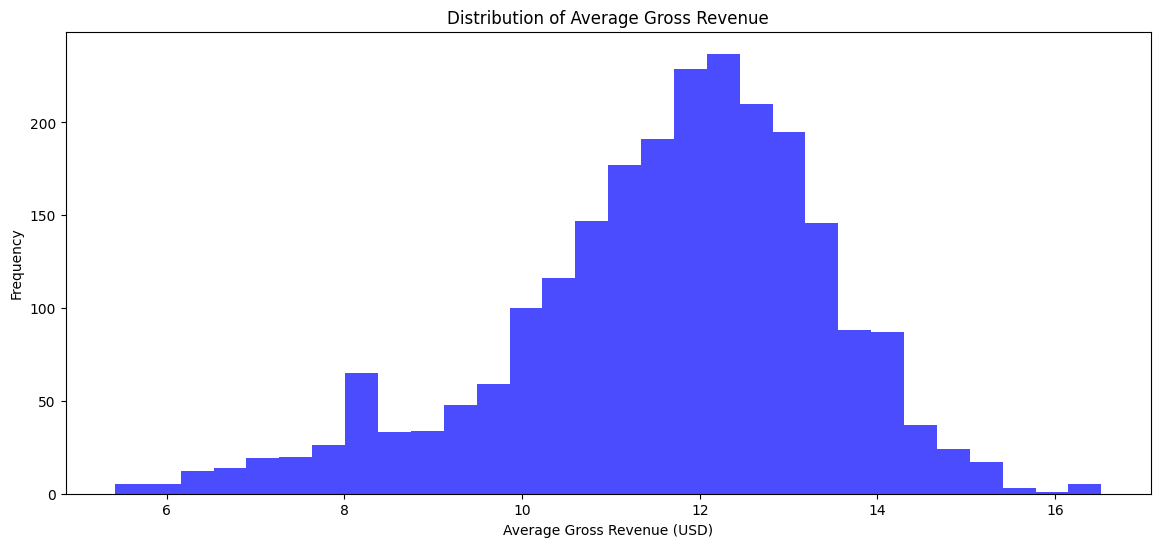

In [6]:
# Histograms for average gross revenue and log
plt.figure(figsize=(14, 6))

plt.hist(data['Avg. Gross USD'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Average Gross Revenue')
plt.xlabel('Average Gross Revenue (USD)')
plt.ylabel('Frequency')

plt.figure(figsize=(14, 6))

plt.hist(np.log(data['Avg. Gross USD'].dropna()), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Average Gross Revenue')
plt.xlabel('Average Gross Revenue (USD)')
plt.ylabel('Frequency')


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2350 entries, 100 to 109682
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Event Date                       2350 non-null   datetime64[ns]
 1   Headliner                        2350 non-null   object        
 2   sp artist_name                   92 non-null     object        
 3   sp artist_genre                  92 non-null     object        
 4   sp followers                     92 non-null     float64       
 5   sp popularity                    92 non-null     float64       
 6   yt name                          85 non-null     object        
 7   yt Channel ID                    85 non-null     object        
 8   yt Title                         85 non-null     object        
 9   yt Description                   47 non-null     object        
 10  yt Published At                  85 non-null     object      

In [8]:
# preprocessors
numerical_features = ['Number of Shows', 'Avg. Event Capacity', 'Ticket Price Min USD', 'Ticket Price Max USD', 
                      'Month', 'Day of Week']
categorical_features = ['Market']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Models

In [9]:
# Still working on
# Pipeline for grid search among models and features
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())]) 

model_params = [
    {'model': [LinearRegression()]},
    {'model': [Lasso()], 'model__alpha': [0.001, 0.01, 0.1, 1]},
    {'model': [RandomForestRegressor()], 'model__n_estimators': [50, 100, 200]},
    {'model': [XGBRegressor(objective='reg:squarederror')], 'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]}
]

scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False),
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}

grid_search = GridSearchCV(pipeline, model_params, cv=5, scoring=scoring, refit='RMSE', verbose=3, return_train_score=False)

grid_search.fit(data[features], data[target])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE score: ", -grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=LinearRegression(); MAE: (test=-206436.889) R2: (test=0.578) RMSE: (test=-287004.806) total time=   0.0s
[CV 2/5] END model=LinearRegression(); MAE: (test=-240672.136) R2: (test=0.611) RMSE: (test=-788335.396) total time=   0.0s
[CV 3/5] END model=LinearRegression(); MAE: (test=-269886.369) R2: (test=0.480) RMSE: (test=-537494.938) total time=   0.0s
[CV 4/5] END model=LinearRegression(); MAE: (test=-283231.003) R2: (test=0.582) RMSE: (test=-507210.057) total time=   0.0s
[CV 5/5] END model=LinearRegression(); MAE: (test=-330527.738) R2: (test=-5.424) RMSE: (test=-1841427.791) total time=   0.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-206603.263) R2: (test=0.578) RMSE: (test=-287134.426) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48051132263937.8, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-240779.308) R2: (test=0.612) RMSE: (test=-788261.835) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67328492406101.44, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-266524.239) R2: (test=0.483) RMSE: (test=-535785.227) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71954715808101.44, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-283231.347) R2: (test=0.582) RMSE: (test=-507205.778) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4971144569877.1875, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-330464.467) R2: (test=-5.424) RMSE: (test=-1841432.998) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66715460978463.59, tolerance: 155902879806.6466
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-206601.815) R2: (test=0.578) RMSE: (test=-287132.865) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48051355895869.06, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-240777.200) R2: (test=0.612) RMSE: (test=-788262.139) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67328743128994.19, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-266542.878) R2: (test=0.483) RMSE: (test=-535793.834) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71954991931784.6, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-283231.011) R2: (test=0.582) RMSE: (test=-507204.861) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4971205739430.8125, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-330463.566) R2: (test=-5.424) RMSE: (test=-1841431.979) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58143976783843.5, tolerance: 155902879806.6466
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-206588.521) R2: (test=0.578) RMSE: (test=-287118.743) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45059680653878.484, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-240756.558) R2: (test=0.612) RMSE: (test=-788265.351) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46276380968845.97, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-266685.819) R2: (test=0.483) RMSE: (test=-535860.474) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65251801246348.94, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-283226.059) R2: (test=0.582) RMSE: (test=-507195.175) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1474529099829.9375, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-330457.290) R2: (test=-5.424) RMSE: (test=-1841421.747) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18821936665372.0, tolerance: 155902879806.6466
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=1; MAE: (test=-206466.217) R2: (test=0.578) RMSE: (test=-287011.384) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6146917654988.625, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=1; MAE: (test=-240646.256) R2: (test=0.611) RMSE: (test=-788295.687) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38084512769652.91, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=1; MAE: (test=-267706.314) R2: (test=0.482) RMSE: (test=-536360.967) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12823923149890.125, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=1; MAE: (test=-283200.333) R2: (test=0.582) RMSE: (test=-507109.730) total time=   0.2s
[CV 5/5] END model=Lasso(), model__alpha=1; MAE: (test=-330408.204) R2: (test=-5.424) RMSE: (test=-1841324.268) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-105546.314) R2: (test=0.760) RMSE: (test=-216321.861) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-167487.933) R2: (test=0.725) RMSE: (test=-663137.016) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-124869.734) R2: (test=0.569) RMSE: (test=-489082.455) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-160642.876) R2: (test=0.784) RMSE: (test=-364732.699) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-95775.121) R2: (test=0.865) RMSE: (test=-266700.492) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-103127.266) R2: (test=0.784) RMSE: (test=-205122.109) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-161939.949) R2: (test=0.756) RMSE: (test=-625067.671) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-121278.343) R2: (test=0.580) RMSE: (test=-482971.386) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-158565.986) R2: (test=0.805) RMSE: (test=-345996.023) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-94565.966) R2: (test=0.879) RMSE: (test=-253173.571) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-104337.156) R2: (test=0.777) RMSE: (test=-208605.440) total time=   2.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-161425.639) R2: (test=0.762) RMSE: (test=-616882.789) total time=   2.4s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-121530.842) R2: (test=0.590) RMSE: (test=-477169.688) total time=   2.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-158912.603) R2: (test=0.797) RMSE: (test=-353791.822) total time=   2.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-91913.395) R2: (test=0.892) RMSE: (test=-238664.095) total time=   2.8s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-114277.935) R2: (test=0.761) RMSE: (test=-215876.480) total time=   4.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-143569.504) R2: (test=0.883) RMSE: (test=-433194.907) total time=   0.5s
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-155133.404) R2: (test=0.786) RMSE: (test=-363221.260) total time=   0.3s
[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-138859.301) R2: (test=0.888) RMSE: (test=-423438.841) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-120460.445) R2: (test=0.816) RMSE: (test=-319872.648) total time=   0.3s
[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-175797.575) R2: (test=0.422) RMSE: (test=-552118.559) total time=   7.9s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=50; MAE: (test=-105614.680) R2: (test=0.790) RMSE: (test=-202391.129) total time=   3.1s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=50; MAE: (test=-118088.328) R2: (test=0.813) RMSE: (test=-322308.552) total time=   0.0s
[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-107056.921) R2: (test=0.792) RMSE: (test=-201355.470) total time=  19.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-140209.608) R2: (test=0.879) RMSE: (test=-440363.608) total time=   7.8s
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

In [10]:

results = grid_search.cv_results_
for mean_rmse, mean_r2, mean_mae, params in zip(results['mean_test_RMSE'], results['mean_test_R2'], results['mean_test_MAE'], results['params']):
    print(f"Params: {params} - RMSE: {-mean_rmse}, R^2: {mean_r2}, MAE: {-mean_mae}")

Params: {'model': LinearRegression()} - RMSE: 792294.5977808923, R^2: -0.634597820478969, MAE: 266150.82690874545
Params: {'model': Lasso(), 'model__alpha': 0.001} - RMSE: 791964.052685181, R^2: -0.6340048548384282, MAE: 265520.5246798942
Params: {'model': Lasso(), 'model__alpha': 0.01} - RMSE: 791965.1356992831, R^2: -0.6340055930650547, MAE: 265523.2941614849
Params: {'model': Lasso(), 'model__alpha': 0.1} - RMSE: 791972.297983644, R^2: -0.6340061515315764, MAE: 265542.84960083786
Params: {'model': Lasso(), 'model__alpha': 1} - RMSE: 792020.4070986457, R^2: -0.633977954513369, MAE: 265685.46481014375
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 50} - RMSE: 399994.90480283025, R^2: 0.7407580601744106, MAE: 130864.39556973272
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 100} - RMSE: 382466.1520613961, R^2: 0.7608586456738429, MAE: 127895.5019178533
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 200} - RMSE: 379022.76671181154

In [11]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())]) 

model_params = [
    {'model': [LinearRegression()]},
    {'model': [Lasso()], 'model__alpha': [0.001, 0.01, 0.1, 1]},
    {'model': [RandomForestRegressor()], 'model__n_estimators': [50, 100, 200]},
    {'model': [XGBRegressor(objective='reg:squarederror')], 'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]}
]

scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(np.exp(y_true)-1, np.exp(y_pred)-1, squared=False), greater_is_better=False),
    'R2': 'r2',
    'MAE': make_scorer(lambda y_true, y_pred:mean_absolute_error(np.exp(y_true)-1, np.exp(y_pred)-1), greater_is_better=False)
}

grid_search = GridSearchCV(pipeline, model_params, cv=5, scoring=scoring, refit='RMSE', verbose=3, return_train_score=False)

grid_search.fit(data[features], np.log(data[target]+1))

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE score: ", -grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=LinearRegression(); MAE: (test=-226393.953) R2: (test=0.493) RMSE: (test=-734979.849) total time=   0.0s
[CV 2/5] END model=LinearRegression(); MAE: (test=-12346645.703) R2: (test=0.574) RMSE: (test=-156692090.108) total time=   0.0s
[CV 3/5] END model=LinearRegression(); MAE: (test=-29727212.781) R2: (test=0.506) RMSE: (test=-462450352.372) total time=   0.0s
[CV 4/5] END model=LinearRegression(); MAE: (test=-1006829957.290) R2: (test=0.259) RMSE: (test=-15744788038.758) total time=   0.0s
[CV 5/5] END model=LinearRegression(); MAE: (test=-549771953375330510569472.000) R2: (test=-0.909) RMSE: (test=-11918771930761972429094912.000) total time=   0.0s
[CV 1/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-229235.041) R2: (test=0.496) RMSE: (test=-808460.824) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-12028236.040) R2: (test=0.583) RMSE: (test=-152692304.932) total tim

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 3/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-32135247.142) R2: (test=0.497) RMSE: (test=-471579930.222) total time=   0.0s
[CV 4/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-3049458455.884) R2: (test=0.273) RMSE: (test=-51174176912.323) total time=   0.0s
[CV 5/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-26704442217733587914981376.000) R2: (test=-1.181) RMSE: (test=-578938511463288216534122496.000) total time=   0.0s
[CV 1/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-250907.911) R2: (test=0.440) RMSE: (test=-967612.170) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-7270893.807) R2: (test=0.460) RMSE: (test=-88418594.910) total time=   0.0s
[CV 3/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-29107065.770) R2: (test=0.391) RMSE: (test=-430091398.142) total time=   0.0s
[CV 4/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-1611088748.136) R2: (test=0.325) RMSE: (test=-25126086515.463) total time=   0.0s
[CV 5/5

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-108229.571) R2: (test=0.912) RMSE: (test=-215834.072) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-164989.208) R2: (test=0.912) RMSE: (test=-666564.331) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-105494.983) R2: (test=0.910) RMSE: (test=-314358.384) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-146252.414) R2: (test=0.873) RMSE: (test=-301814.942) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-122701.541) R2: (test=0.926) RMSE: (test=-384284.413) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-108773.712) R2: (test=0.912) RMSE: (test=-217270.669) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-164190.928) R2: (test=0.910) RMSE: (test=-662836.753) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-105825.288) R2: (test=0.913) RMSE: (test=-368674.045) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-149769.852) R2: (test=0.876) RMSE: (test=-333789.156) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-109934.861) R2: (test=0.924) RMSE: (test=-337027.005) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-108025.999) R2: (test=0.913) RMSE: (test=-215058.338) total time=   2.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-164627.277) R2: (test=0.914) RMSE: (test=-677702.965) total time=   2.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-105548.133) R2: (test=0.911) RMSE: (test=-350080.581) total time=   2.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-146885.242) R2: (test=0.876) RMSE: (test=-317394.229) total time=   2.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-105683.109) R2: (test=0.926) RMSE: (test=-317783.072) total time=   2.4s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-115881.372) R2: (test=0

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-159574.930) R2: (test=0.907) RMSE: (test=-596783.931) total time=   0.3s
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-137805.610) R2: (test=0.868) RMSE: (test=-279501.151) total time=   0.1s
[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-115454.629) R2: (test=0.905) RMSE: (test=-233325.448) total time=   7.1s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-158551.313) R2: (test=0.908) RMSE: (test=-546710.785) total time=   0.9s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-114154.214) R2: (test=0.908) RMSE: (test=-316844.860) total time=   3.6s
[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=50; MAE: (test=-111979.962) R2: (test=0.909) RMSE: (test=-224349.240) total time=   0.1s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=50; MAE: (test=-116377.320) R2: (test=0.904) RMSE: (test=-395010.277) total time=   0.2s
[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-112590.453) R2: (test=0.906) RMSE: (test=-229370.536) total time=   0.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-166347.324) R2: (test=0.912) RMSE: (test=-689828.020) total time=   4.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-115292.457) R2: (test=0.901) RMSE: (test=-389289.314) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-133803.501) R2: (test=0.882) RMSE: (test=-282473.256) total time=   0.3s
[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

In [12]:

results = grid_search.cv_results_
for mean_rmse, mean_r2, mean_mae, params in zip(results['mean_test_RMSE'], results['mean_test_R2'], results['mean_test_MAE'], results['params']):
    print(f"Params: {params} - RMSE: {-mean_rmse}, R^2: {mean_r2}, MAE: {-mean_mae}")

Params: {'model': LinearRegression()} - RMSE: 2.383754386152398e+24, R^2: 0.18471289880746017, MAE: 1.0995439067506631e+23
Params: {'model': Lasso(), 'model__alpha': 0.001} - RMSE: 3.5402627557419813e+24, R^2: 0.1854128113356502, MAE: 1.6330014383971604e+23
Params: {'model': Lasso(), 'model__alpha': 0.01} - RMSE: 1.1578770229265766e+26, R^2: 0.12636476494133744, MAE: 5.340888443546719e+24
Params: {'model': Lasso(), 'model__alpha': 0.1} - RMSE: 6.766892601641993e+25, R^2: 0.07484721277456866, MAE: 3.121334803197257e+24
Params: {'model': Lasso(), 'model__alpha': 1} - RMSE: 813096.9875069906, R^2: 0.07429923554370292, MAE: 314193.9688901492
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 50} - RMSE: 376571.22854592593, R^2: 0.9066652778010343, MAE: 129533.54336402325
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 100} - RMSE: 383919.52562494826, R^2: 0.9072205614365101, MAE: 127698.92835160784
Params: {'model': RandomForestRegressor(), 'model__n_estima

                                 Feature    Importance
1               num__Avg. Event Capacity  8.066563e-01
2              num__Ticket Price Min USD  9.369445e-02
3              num__Ticket Price Max USD  6.357490e-02
4                             num__Month  7.837675e-03
5                       num__Day of Week  5.624419e-03
..                                   ...           ...
151       cat__Market_Wausau-Rhinelander  1.025354e-06
16      cat__Market_Beaumont-Port Arthur  9.851429e-07
117  cat__Market_Quincy-Hannibal-Keokuk   8.533375e-07
99     cat__Market_Myrtle Beach-Florence  8.197227e-07
9               cat__Market_Amarillo, TX  5.236640e-07

[158 rows x 2 columns]


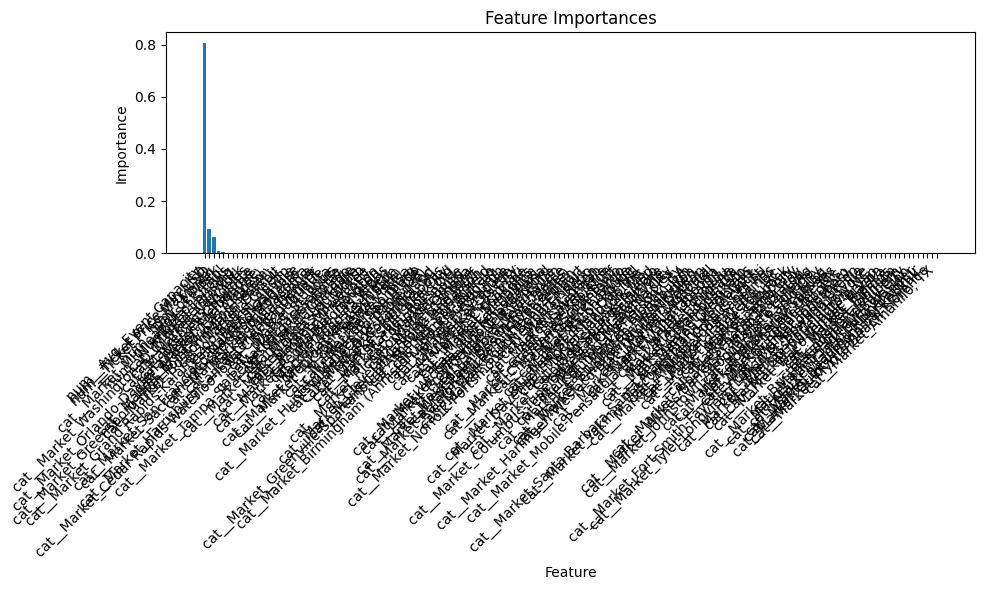

In [ ]:
## get and plot the feature importance

preprocessor = pipeline.named_steps['preprocessor']
random_forest = pipeline.named_steps['random_forest']


transformed_features = preprocessor.get_feature_names_out(features)
feature_importances = random_forest.feature_importances_

importance_df = pd.DataFrame({
    'Feature': transformed_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [24]:
importance_df


,Feature,Importance
1,num__Avg. Event Capacity,8.066563e-01
2,num__Ticket Price Min USD,9.369445e-02
3,num__Ticket Price Max USD,6.357490e-02
4,num__Month,7.837675e-03
5,num__Day of Week,5.624419e-03
...,...,...
151,cat__Market_Wausau-Rhinelander,1.025354e-06
16,cat__Market_Beaumont-Port Arthur,9.851429e-07
117,cat__Market_Quincy-Hannibal-Keokuk,8.533375e-07
99,cat__Market_Myrtle Beach-Florence,8.197227e-07
